In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement

In [2]:
def extract_data(file_name):
    data_text = open(file_name, 'r')
    data_list = []
    event_counter = 0
    for line in data_text:
        line_data = list(map(float, line.split()))
        line_data = line_data[0:2]
        data_list.append(line_data)
        event_counter += 1
    first_event_time = data_list[0][0]
    last_event_time = data_list[-1][0]
    normolized_events = np.linspace(first_event_time,
                                    last_event_time, event_counter)
    for i in range(0, event_counter):
        data_list[i][0] = normolized_events[i]

    return data_list

In [3]:
data = extract_data('wnaap.dat')

In [4]:
def add_graph_parametrs(fig_size_x = 15, figsize_y = 15, #размеры окна с графиком
                    left_border = 1900, right_border = 2016, #границы, в которых показывается график по оси абсцисс
                    lower_border = -30, upper_border = 30 #границы, в которых показывается график по оси ординат
                   ):
    plt.figure(figsize=(fig_size_x, figsize_y))
    axes = plt.gca()
    axes.set_xlim([left_border, right_border])
    axes.set_ylim([lower_border, upper_border])
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('number')

In [5]:
month = 1 / 12
activity_minimums_list = [1902 + 1 * month,
                          1913 + 7 * month,
                          1923 + 7 * month,
                          1933 + 8 * month,
                          1944 + 1 * month,
                          1954 + 3 * month,
                          1964 + 9 * month,
                          1976 + 5 * month,
                          1986 + 8 * month,
                          1996 + 4 * month,
                          2009 + 0 * month]

In [6]:
def get_changed_data(data, minimums):
    i = 0
    j = 0
    event_num = len(data)
    minimums_num = len(minimums)
    changed_data = []
    sign = -1
    while (i < event_num):
        while (i < event_num and
               (j >= minimums_num or data[i][0] < minimums[j])):
            data_pair = [data[i][0], sign * np.sqrt(data[i][1])]
            changed_data.append(data_pair)
            i += 1
        j += 1
        sign *= -1 
    return changed_data

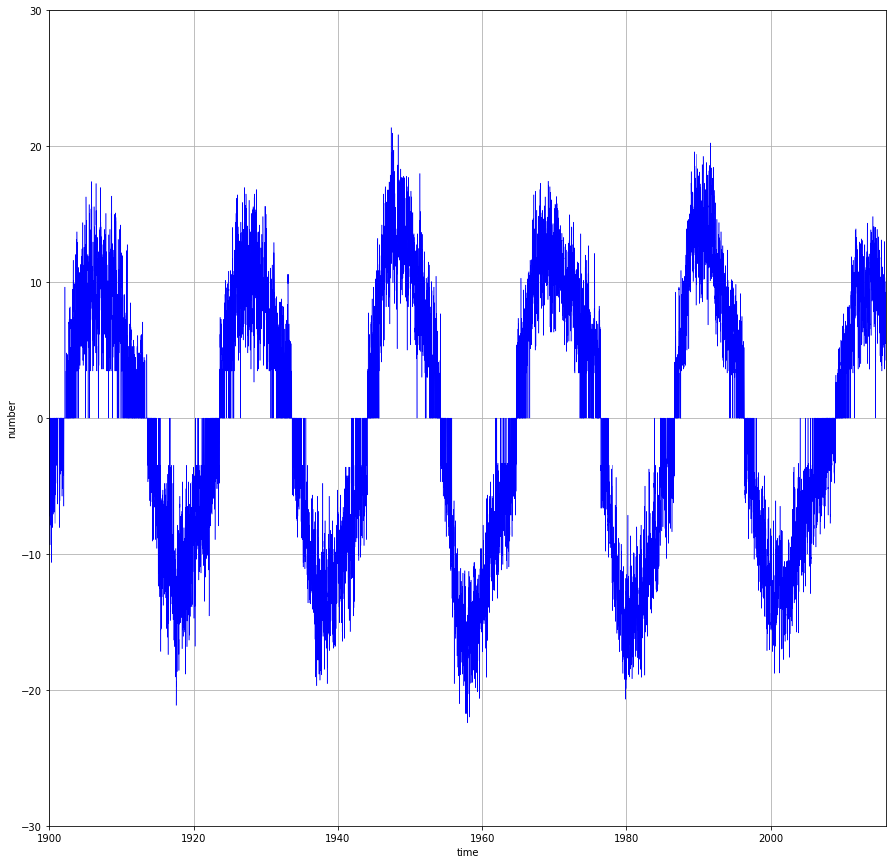

In [7]:
new_data = np.array(get_changed_data(data, activity_minimums_list))
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.5, color='b')
plt.show()

In [8]:
def FFT_low_pass(signal, fc, b):
    
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = list(signal[:,1])
    new_signal_data = np.convolve(s, sinc_func, mode='same')
    new_signal = []
    dots_num = len(s)
    for i in range(0, dots_num):
        append_data = [signal[i][0], new_signal_data[i]]
        new_signal.append(append_data)
    return new_signal

In [9]:
smoothed_data = np.array(FFT_low_pass(new_data, 0.0001, 0.0021))

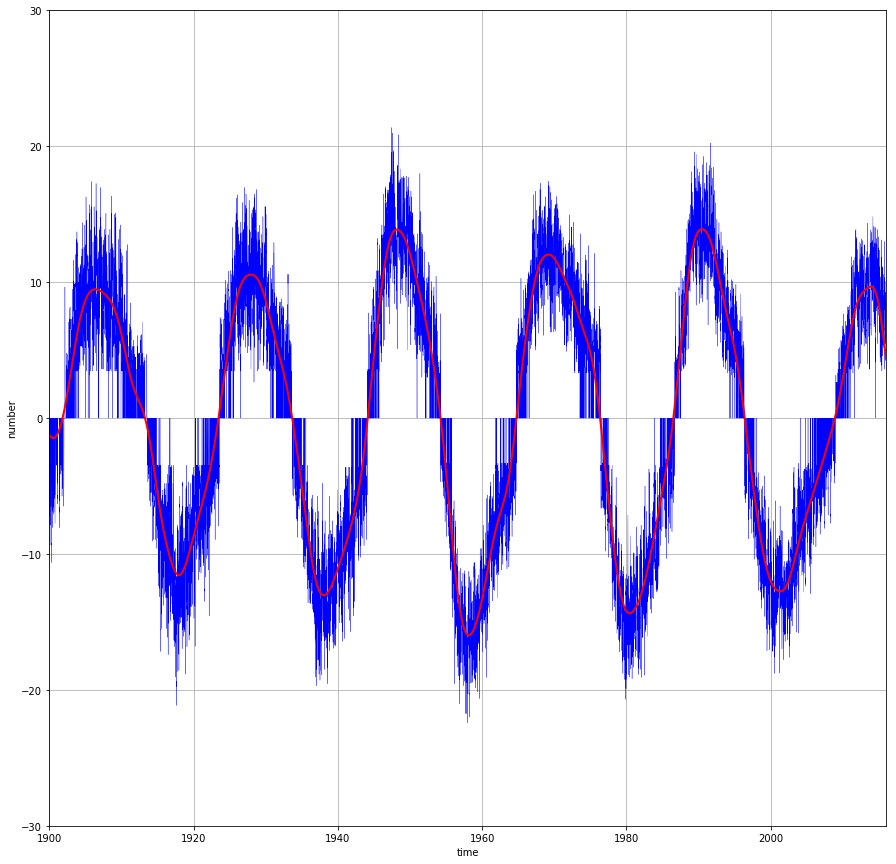

In [10]:
add_graph_parametrs()
plt.plot(new_data[:,0], new_data[:,1], linewidth=0.3, color='b')
plt.plot(smoothed_data[:,0], smoothed_data[:,1], linewidth=2, color='r')
plt.show()

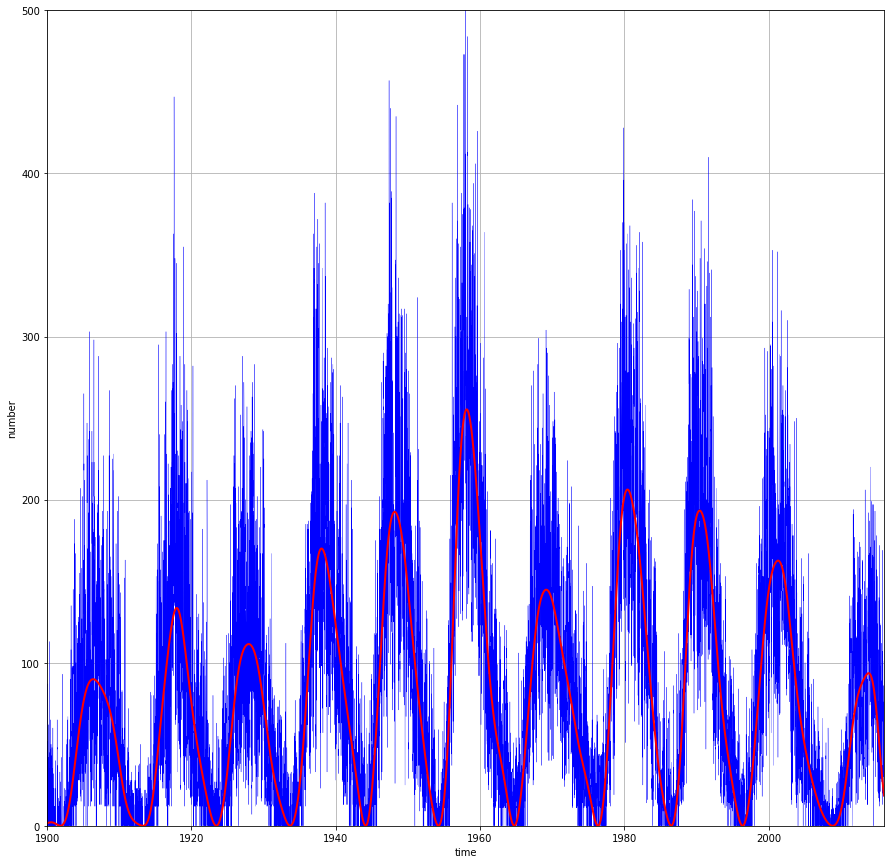

In [11]:
add_graph_parametrs(lower_border=0, upper_border = 500)
plt.plot(new_data[:,0], new_data[:,1] ** 2, linewidth=0.3, color='b')
plt.plot(smoothed_data[:,0], smoothed_data[:,1] ** 2, linewidth=2, color='r')
plt.show()

In [12]:
def find_last_max(data):
    i = np.shape(data)[0] - 1
    while (data[i - 1, 1] > data[i, 1]):
        i -= 1
    return i

In [13]:
def find_first_zero(data):
    i = 0
    while (data[i, 1] < 0):
        i += 1
    return i

In [14]:
def get_cicles_borders(data):
    borders = []
    start = find_first_zero(data)
    finish = find_last_max(data)
    i = start
    while (i <= finish):
        while (i <= finish and (data[i, 1] * data[i + 1, 1] > 0)):
            i += 1
        cicle_borders = [start, i]
        start = i + 1
        borders.append(cicle_borders)
        i += 1
    return borders

In [15]:
def get_derivative (data, index):
    interval = np.array(data[index - 5: index + 5])
    k = np.polyfit(interval[:,0], interval[:, 1], 1)
    return k[0]

In [16]:
cicles = get_cicles_borders(smoothed_data)

In [17]:
def cicle_phase_portrait (start, finish, data):
    portrait = []
    for i in range(start, finish + 1):
        x = get_derivative(data, i)
        append_pair = [data[i][1], x]
        portrait.append(append_pair)
    return portrait

In [18]:
portraits = []
for cicle in cicles:
    portraits.append(np.array(cicle_phase_portrait(cicle[0], cicle[1], smoothed_data)))

In [19]:
def draw_cicles(portraits, number):
    add_graph_parametrs(lower_border=-10, upper_border = 10,
                        left_border = -16, right_border = 16)
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    if (number < 0 or number >= len(portraits)):
        picture = np.concatenate(portraits, axis = 0)
        plt.plot(picture[:,0], picture[:,1], linewidth=0.5, color ='r')
    else:
        plt.plot(portraits[number][:,0], portraits[number][:,1], linewidth=0.5, color ='r')

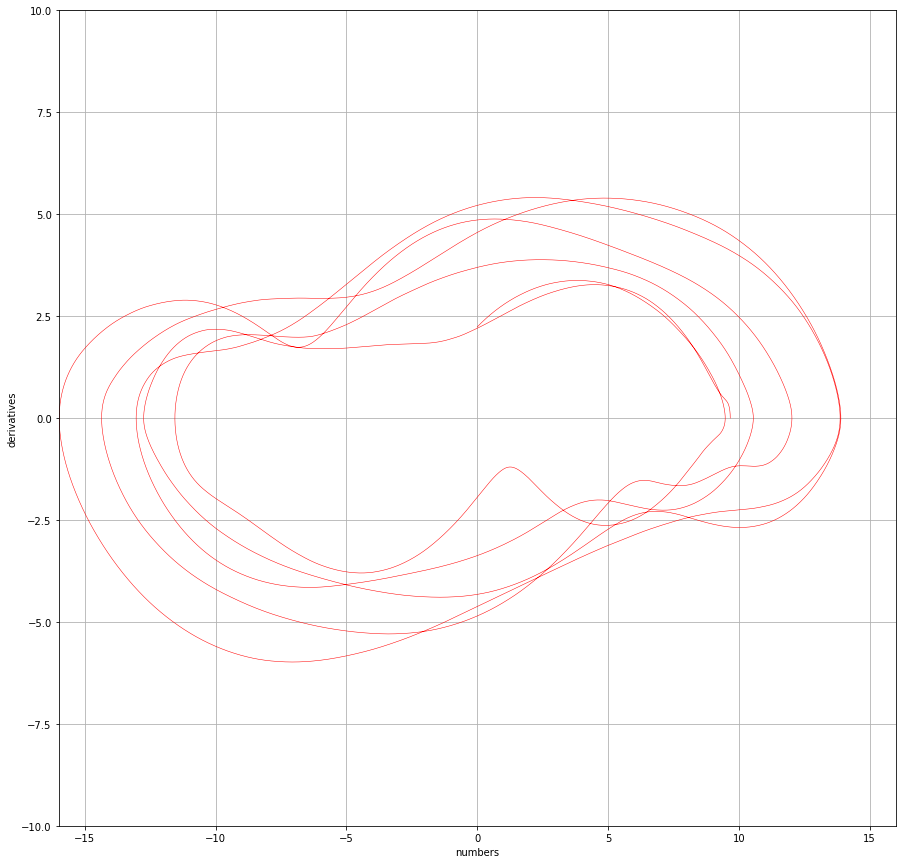

In [20]:
draw_cicles(portraits, -1)

In [21]:
eps = 1
lamda = 1
mu = 1
omega = 1

In [22]:
def VDPD (t, y):
    dydt = [y[1], -lamda * y[0] ** 3 -omega ** 2 * y[0]
           -mu*(eps*y[0] ** 2 - 1) * y[1]]
    return dydt

In [23]:
def difference(data, approx_data):
    int_sum = 0
    events_num = len(data)
    for i in range(1, events_num):
        int_sum += (approx_data[0, i] - data[i, 1]) ** 2 * (data[i, 0] - data[i - 1, 0])
    return int_sum

In [24]:
def find_max(data):
    for i in range(0, len(data)- 1):
        if (abs(data[i + 1, 1]) <= abs(data[i, 1])):
            return data[i, 1]
    return data[-1, 1]

In [25]:
def calculate_approx(data, period, sign, start):
    init_sol = solve_ivp(VDPD, (0, 20 * period), start, method='RK45',
                         t_eval=np.linspace(0, 20 * period, 10000)).y
    i = np.shape(init_sol)[1] - 1
    while (not (init_sol[0, i] * sign <= 0 and init_sol[0, i - 1] * sign > 0)):
        i -= 1
    while (not (init_sol[0, i] * sign >= 0 and init_sol[0, i - 1] * sign < 0)):
        i -= 1
    true_start = [init_sol[0, i], init_sol[1, i]]
    events_num = np.shape(data)[0]
    sol = solve_ivp(VDPD, (data[0, 0], data[-1, 0]), true_start, method='RK45',
                    t_eval=np.linspace(data[0, 0], data[-1, 0], events_num)).y
    return sol

In [26]:
def get_moves(step):
    moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                for t in range (-1, 2):
                    if (k or t or j or i):
                        moves.append([i * step, j * step, k * step, t * step])
    return moves

In [27]:
#условие положительности параметров и повторения
def get_block(move, moves, step):
    global lamda, mu, eps, omega
    blocked_moves = []
    for i in range (-1, 2):
        for j in range (-1, 2):
            for k in range (-1, 2):
                for t in range (-1, 2):
                    v = [i * step + move[0], j * step + move[1], k * step + move[2], t * step + move[3]]
                    if ((i < 0 and lamda < step) or
                        (j < 0 and mu < step) or
                        (k < 0 and eps < step) or
                        (t < 0 and omega < step) or
                        (v in moves)):
                        blocked_moves.append([i * step, j * step, k * step, t * step])
    return blocked_moves.copy()

In [28]:
def get_approx(data):
    global mu, omega, eps, lamda
    t_span = data[-1, 0] - data[0, 0]
    
    max_data = find_max(data)
    sign = np.sign(max_data)
    blocked = []
    
    mu = 0
    omega  = round(np.pi / t_span, 4)
    eps = round((2 / abs(max_data)) ** 2, 4)
    lamda = 0
    init_parameters = [lamda, mu, eps, omega]
    
    step = 0.1
    anti_step = 10
    step_counter = 0
    best_approx = calculate_approx(data, t_span, sign, [max_data, 0])
    best_move = [0, 0, 0, 0]
    min_difference = difference(data, best_approx)
    
    while (step_counter < 10000000 and step > 0.00001):
        moves = get_moves(step)
        blocked = get_block([0, 0, 0, 0], [], step)
        end_flag = 0
        while (not end_flag):
            end_flag = 1
            for move in moves:
                if (not (move in blocked)):
                    step_counter += 1
                    lamda = round(init_parameters[0] + np.sign(move[0]) * 0.0001, 4) #lamda мало по виду данных
                    mu = round(init_parameters[1] + move[1], 4)
                    eps = round(init_parameters[2] + move[2], 4)
                    omega = round(init_parameters[3] + move[3], 4)
                    approx_data = calculate_approx(data, t_span, sign, [max_data, 0])
                    diff = difference(data, approx_data)
                    if (diff < min_difference):
                        end_flag = 0
                        min_difference = diff
                        best_approx = approx_data
                        best_move = move
            if (not end_flag):
                init_parameters = [round(init_parameters[0] + np.sign(move[0]) * 0.0001, 4),
                                   round(init_parameters[1] + best_move[1], 4),
                                   round(init_parameters[2] + best_move[2], 4),
                                   round(init_parameters[3] + best_move[3], 4)]

            if (step_counter >= 10000000):
                end_flag = 1
            lamda, mu, eps, omega = init_parameters
            blocked = get_block(best_move, moves, step)
        step /= 10
        anti_step *= 10
    
    return (best_approx.copy(), min_difference, init_parameters)

In [29]:
def approximate_cicle(number):
    cicle_data = smoothed_data[cicles[number][0] : cicles[number][1] + 1,:]
    approx_data = get_approx(cicle_data)
    return [cicle_data[:, 0], approx_data]

In [30]:
def drow_cicle_results(result_data, num):
    add_graph_parametrs(lower_border=-16, upper_border = 16,
                                left_border = -16, right_border = 16)
    print('cicle ' + str(num + 1))
    print('mistake =', result_data[1][1])
    print('lamda =', result_data[1][2][0])
    print('mu =', result_data[1][2][1])
    print('eps =', result_data[1][2][2])
    print('omega =', result_data[1][2][3])
    plt.xlabel('numbers')
    plt.ylabel('derivatives')
    plt.plot(result_data[1][0][0,:], result_data[1][0][1,:])
    plt.plot(portraits[num][:,0], portraits[num][:,1], color ='r')
    plt.show()
    add_graph_parametrs()
    plt.plot(result_data[0], result_data[1][0][0,:])
    plt.plot(result_data[0], portraits[num][:,0], color ='r')
    plt.show()

cicle 1
mistake = 1.856310738349593
lamda = 0.0002
mu = 0.11
eps = 0.0445
omega = 0.275


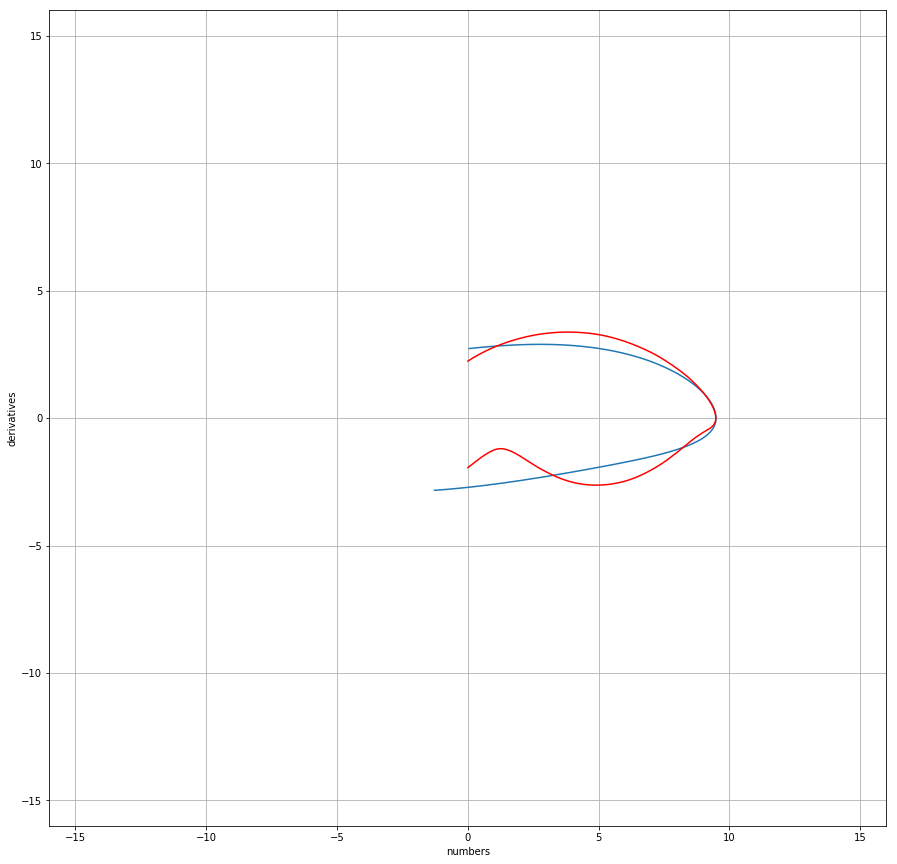

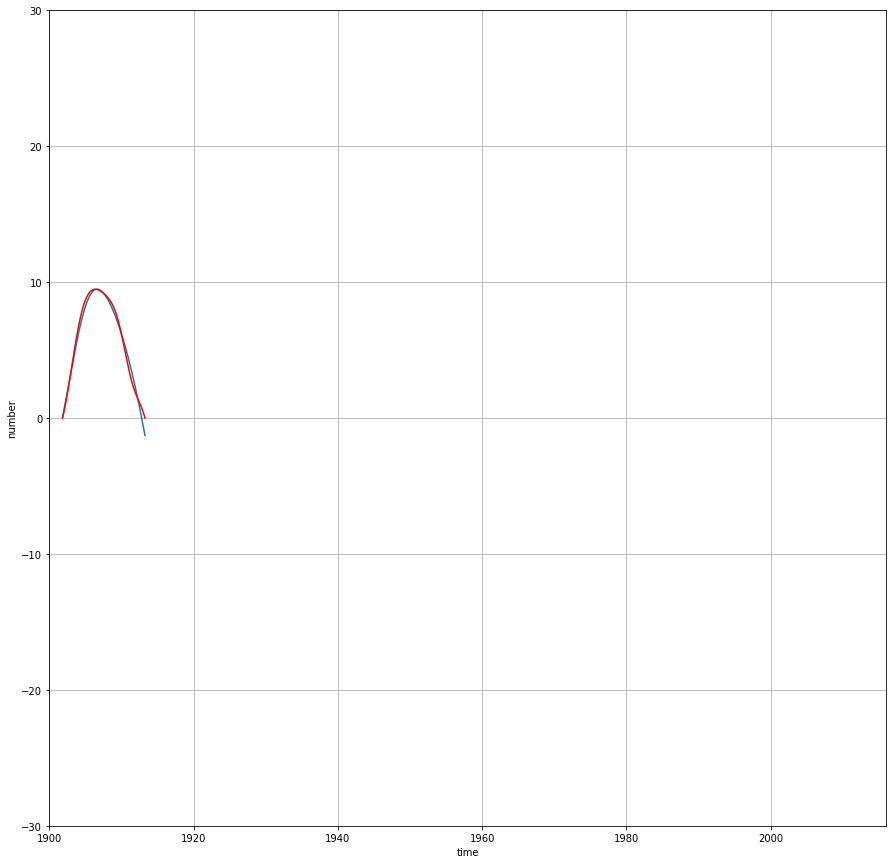

cicle 2
mistake = 2.598984666984287
lamda = 0.0003
mu = 0.0901
eps = 0.03
omega = 0.2986


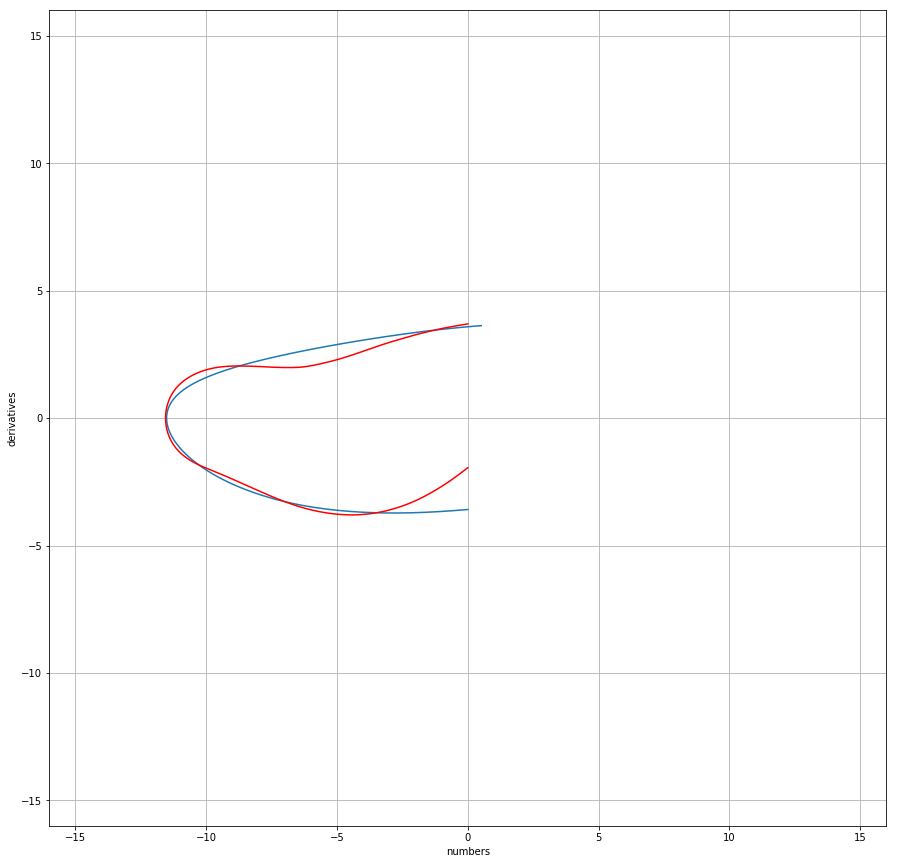

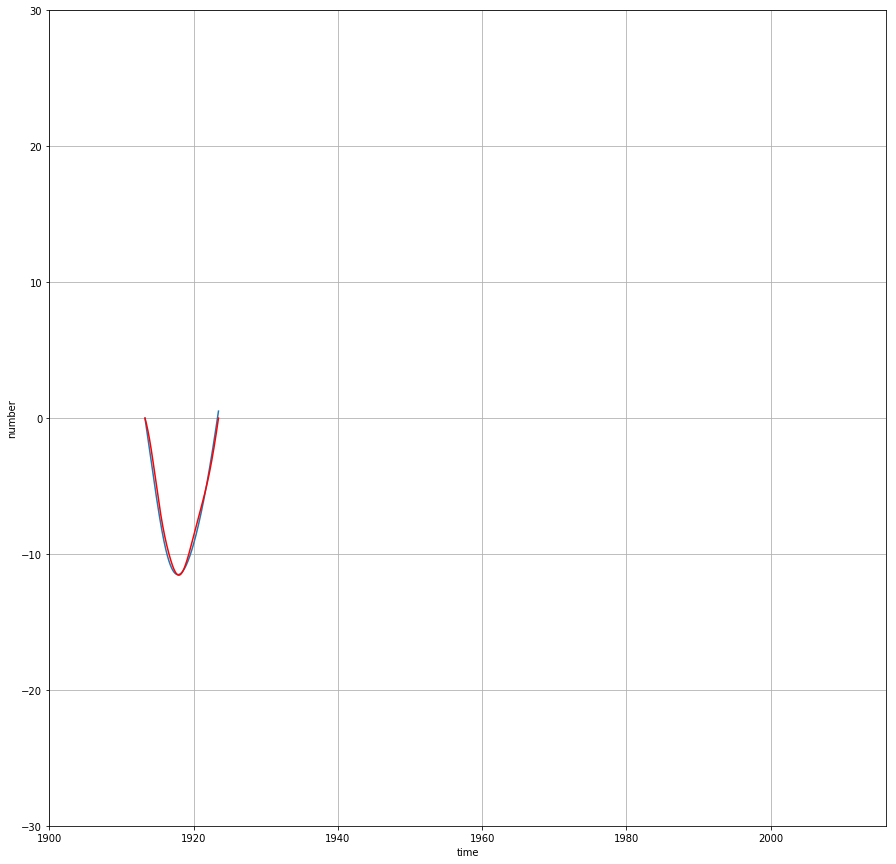

cicle 3
mistake = 0.4187606798119449
lamda = 0.0003
mu = 0.1999
eps = 0.036
omega = 0.3076


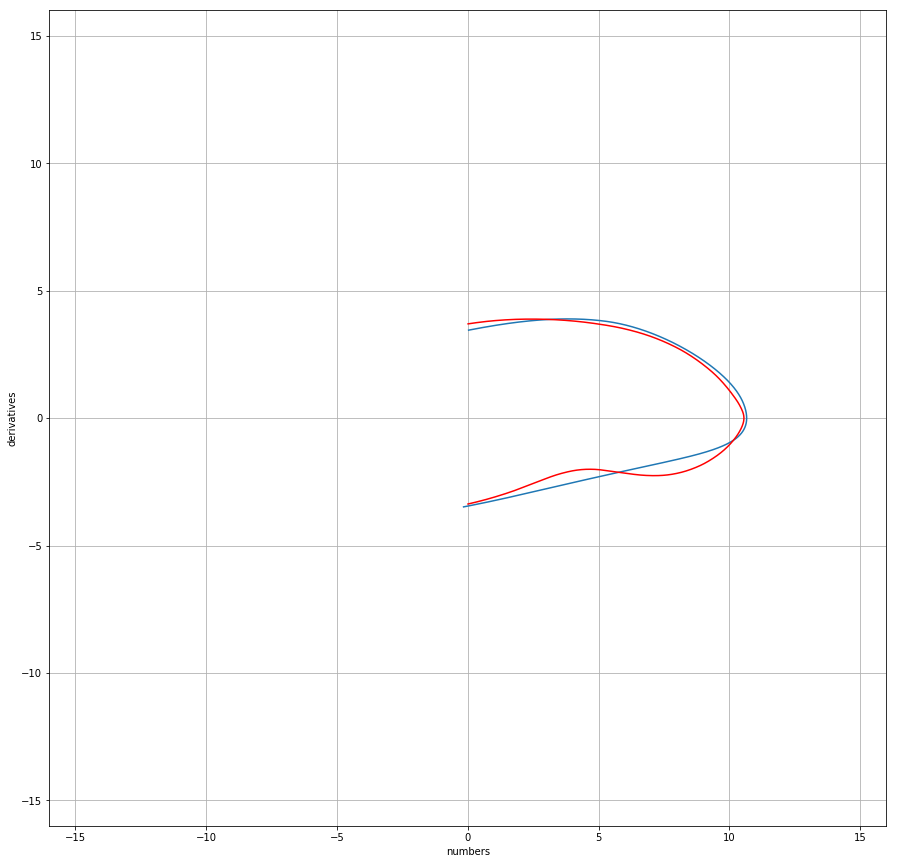

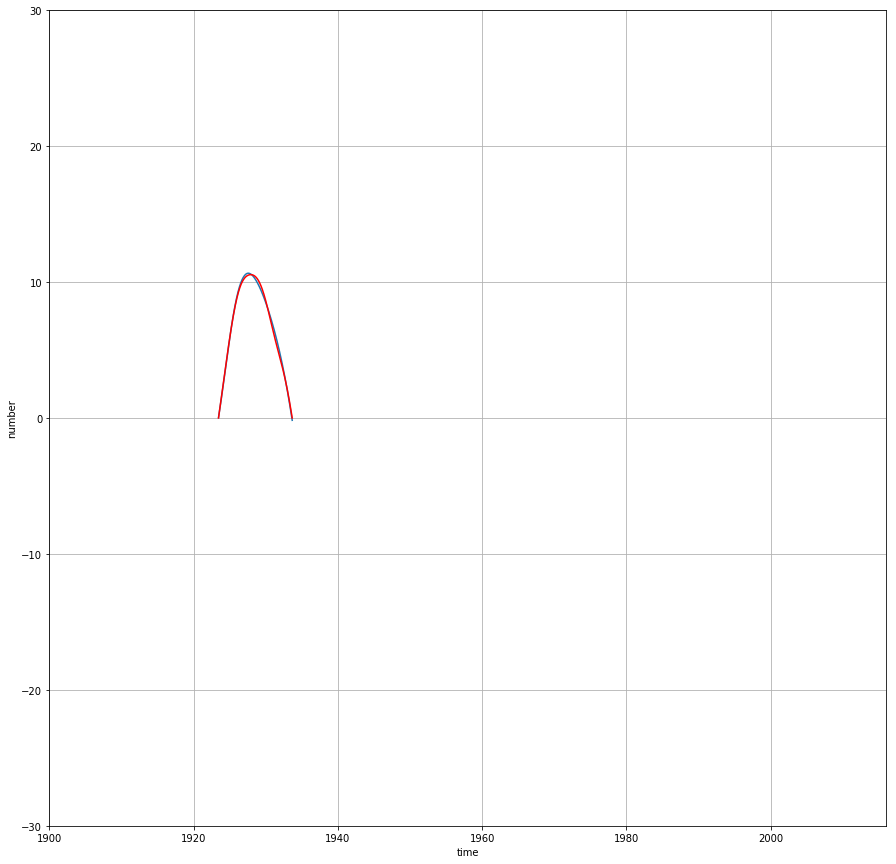

cicle 4
mistake = 1.4227426293361458
lamda = 0.0002
mu = 0.0999
eps = 0.0236
omega = 0.3003


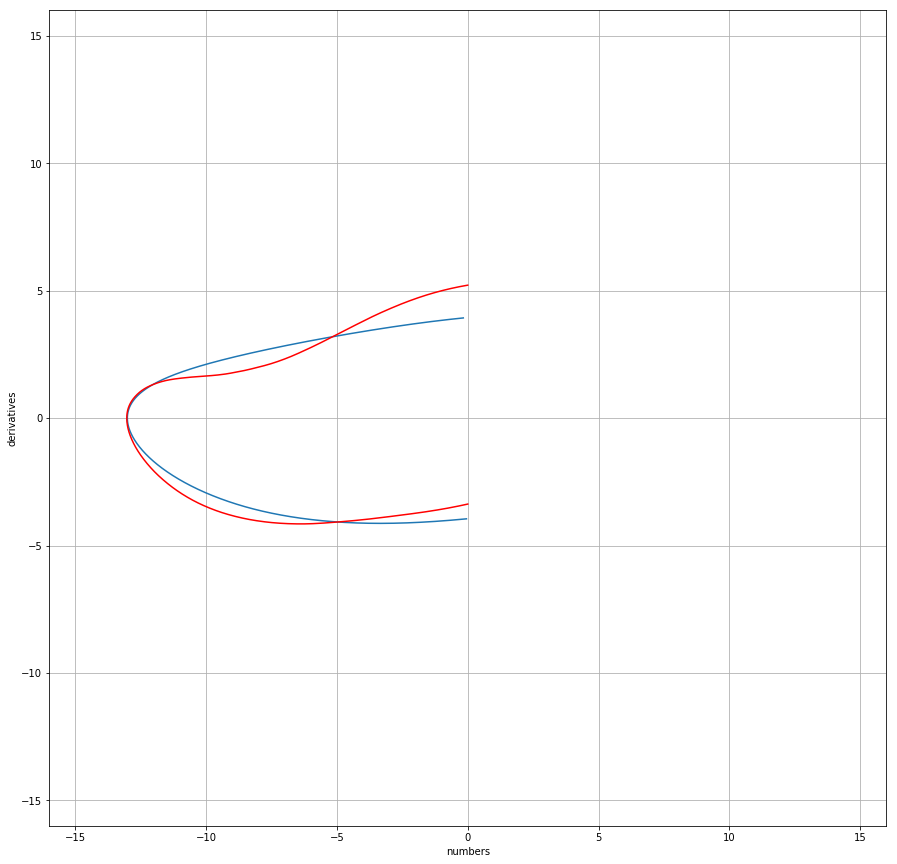

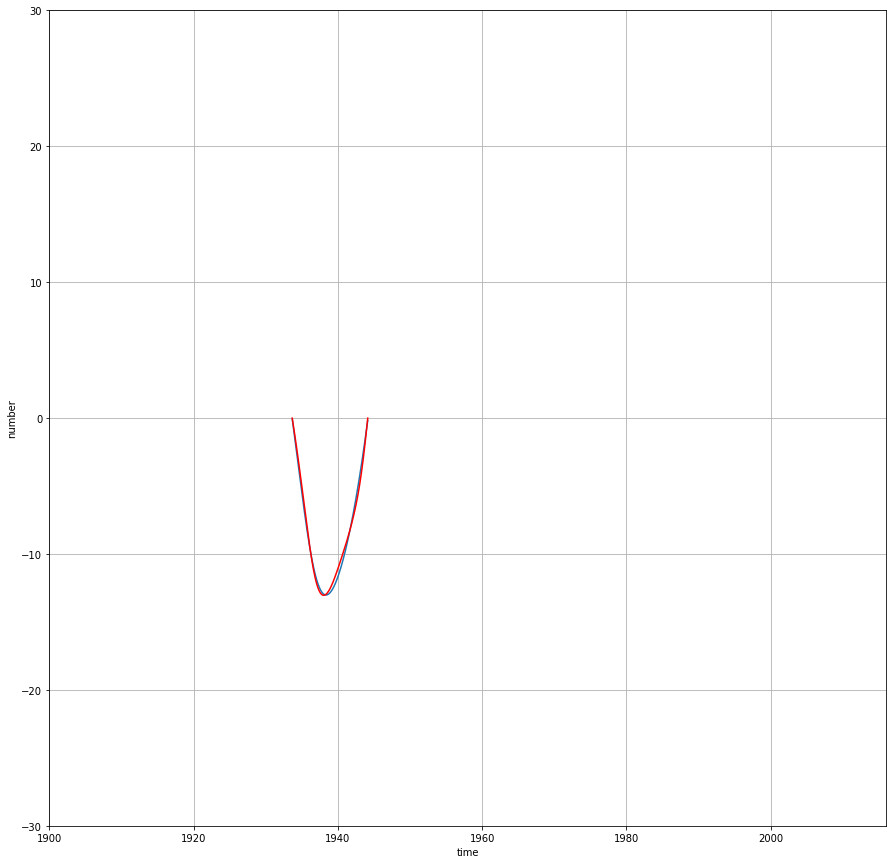

cicle 5
mistake = 4.831441819516989
lamda = 0.0002
mu = 0.1001
eps = 0.0207
omega = 0.3113


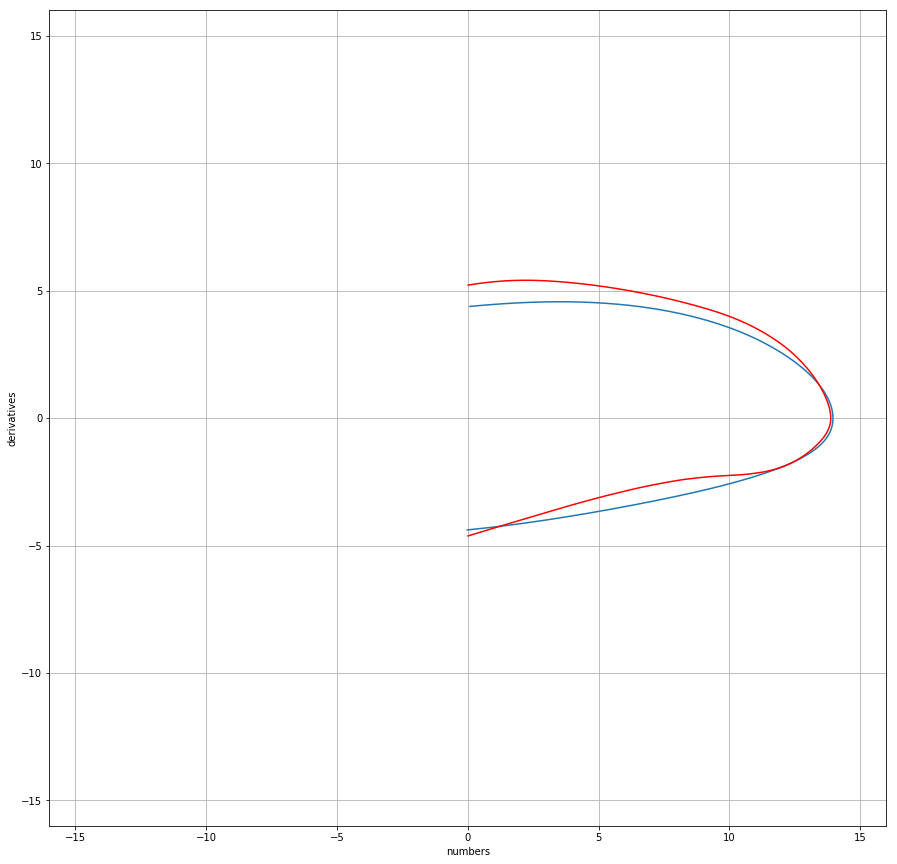

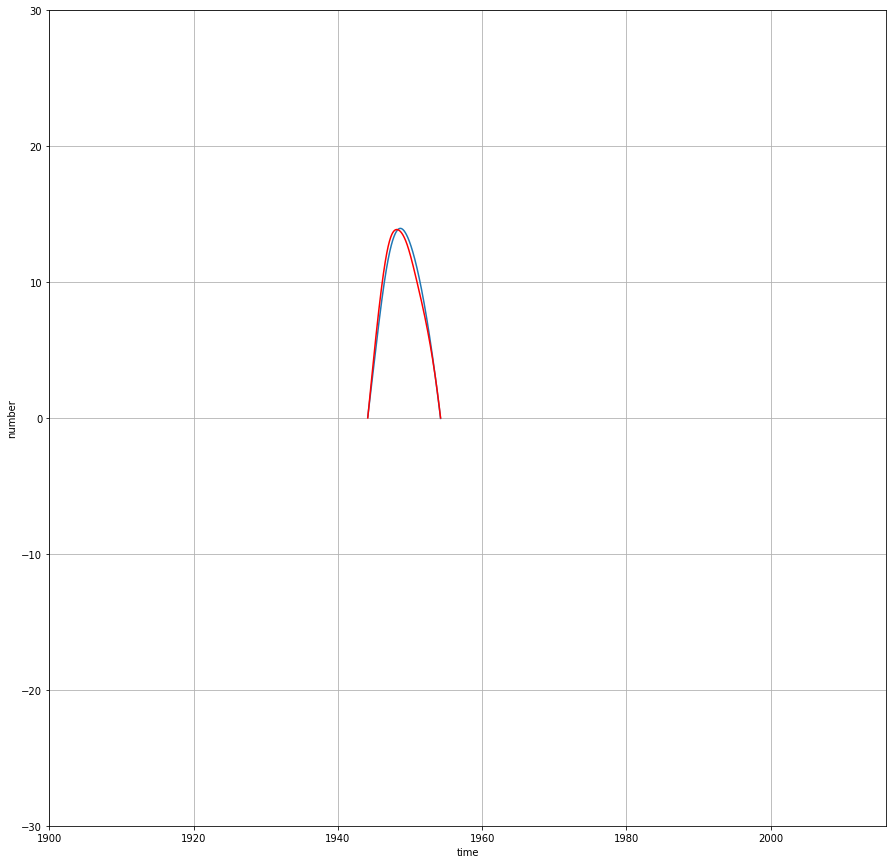

cicle 6
mistake = 1.931094451884855
lamda = 0.0007
mu = 0.2999
eps = 0.0156
omega = 0.1091


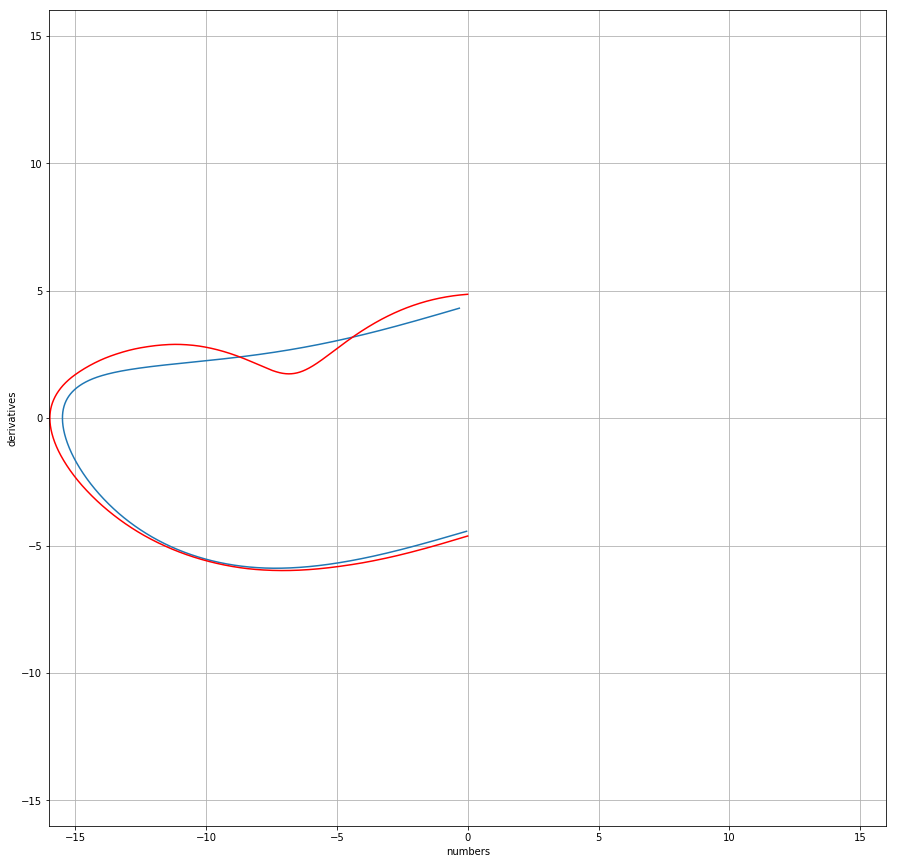

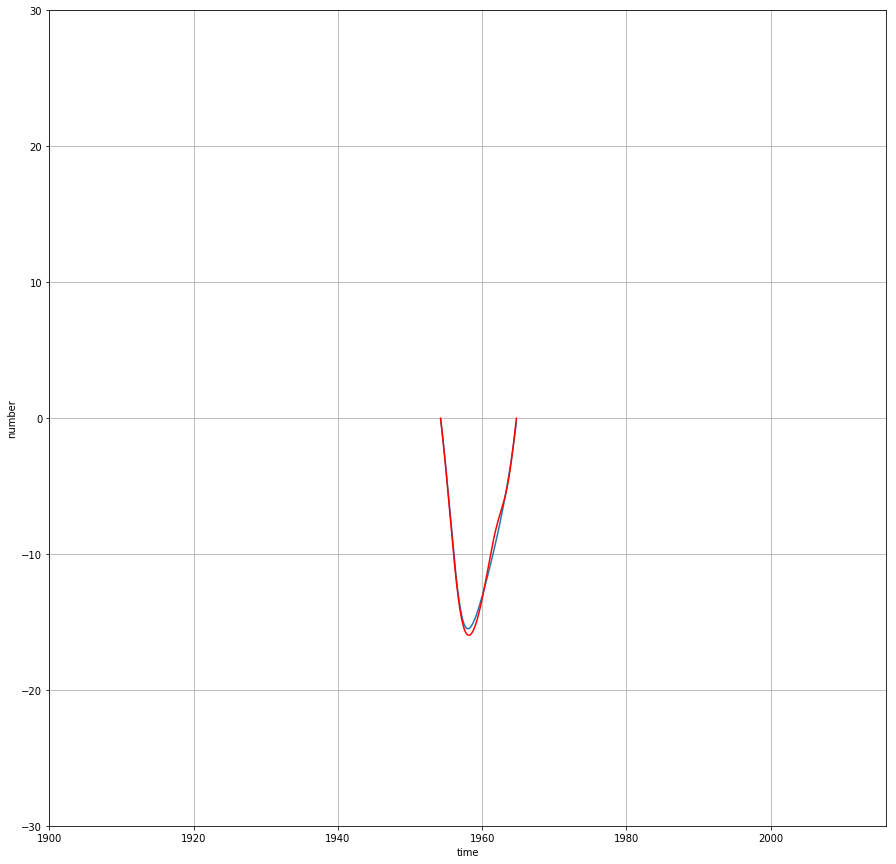

cicle 7
mistake = 8.274571699312666
lamda = 0.0002
mu = 0.1001
eps = 0.0275
omega = 0.2708


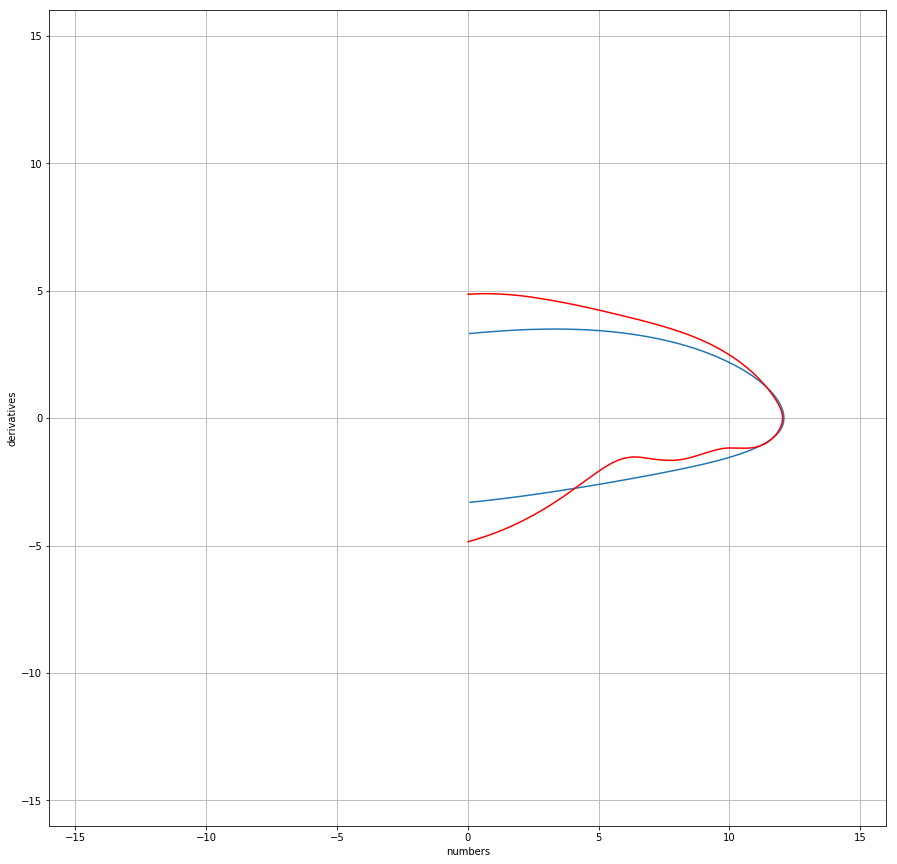

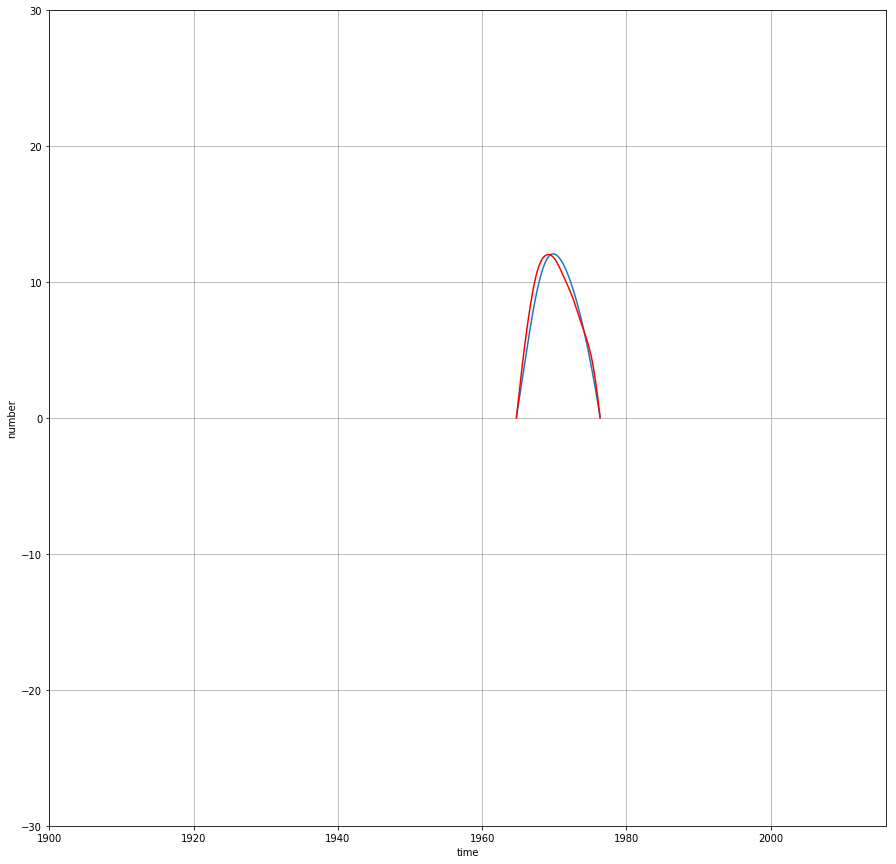

cicle 8
mistake = 3.2254542525325003
lamda = 0.0003
mu = 0.1101
eps = 0.0193
omega = 0.2995


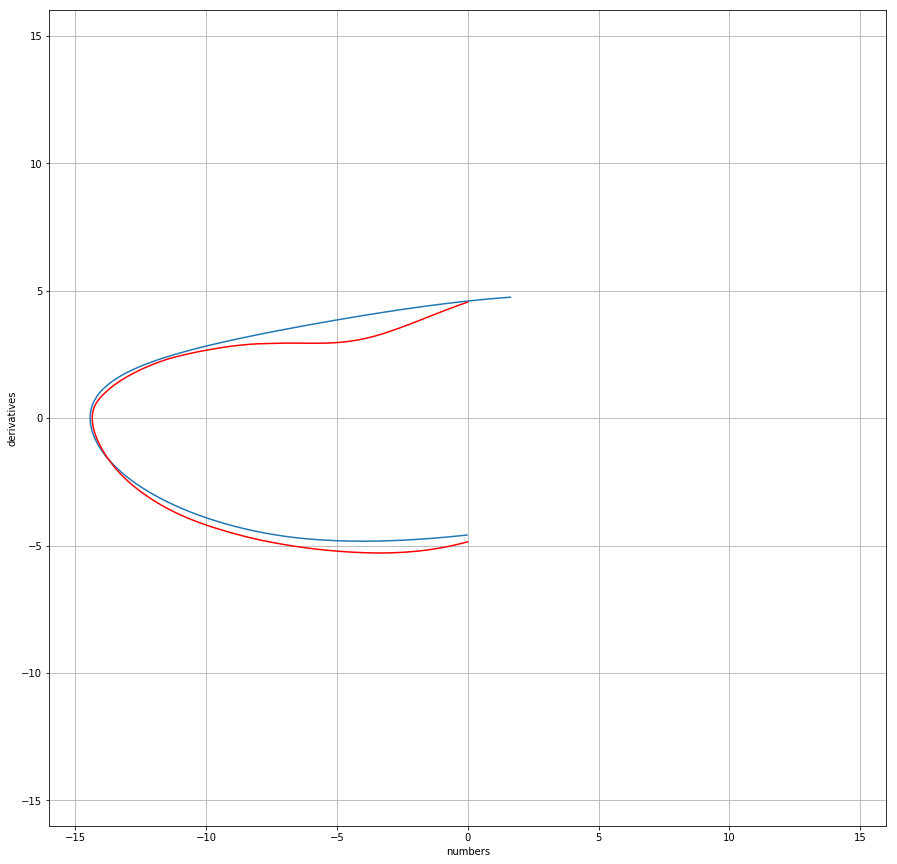

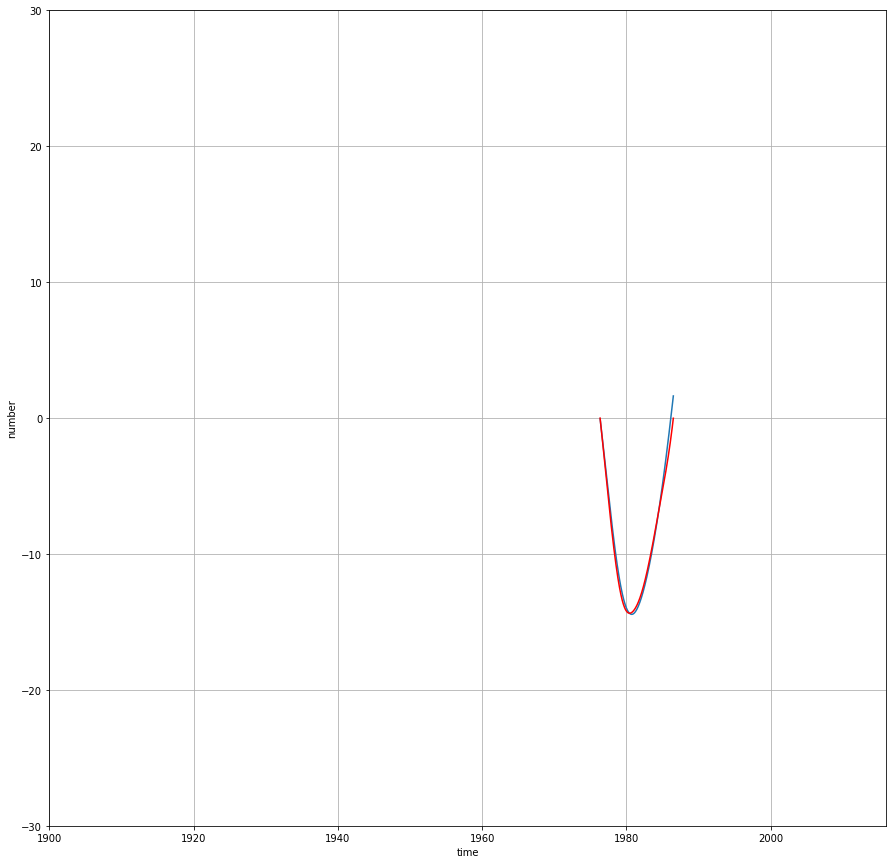

cicle 9
mistake = 2.715601191920876
lamda = 0.0003
mu = 0.2001
eps = 0.0206
omega = 0.318


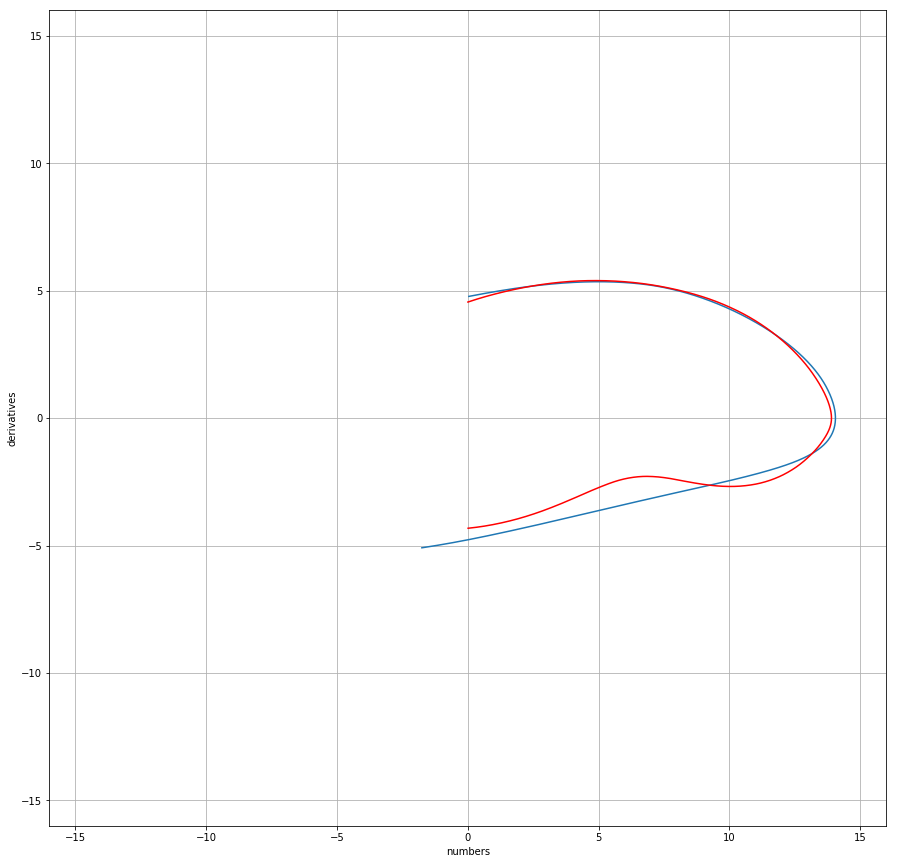

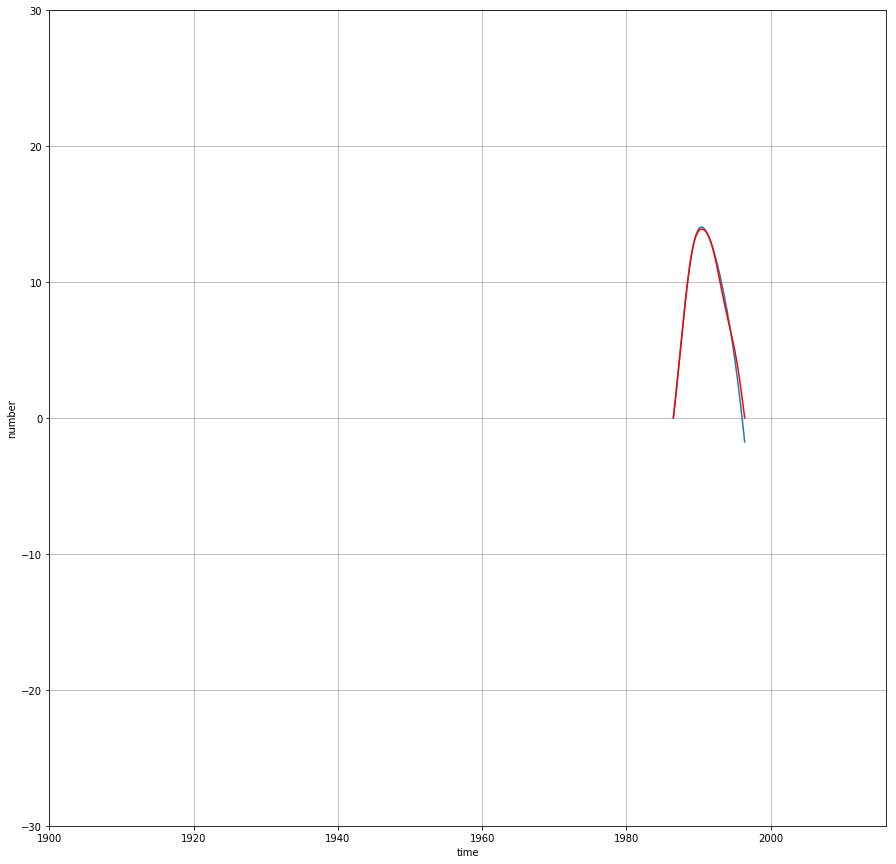

cicle 10
mistake = 6.693113770116754
lamda = 0.0003
mu = 0.2001
eps = 0.0247
omega = 0.2514


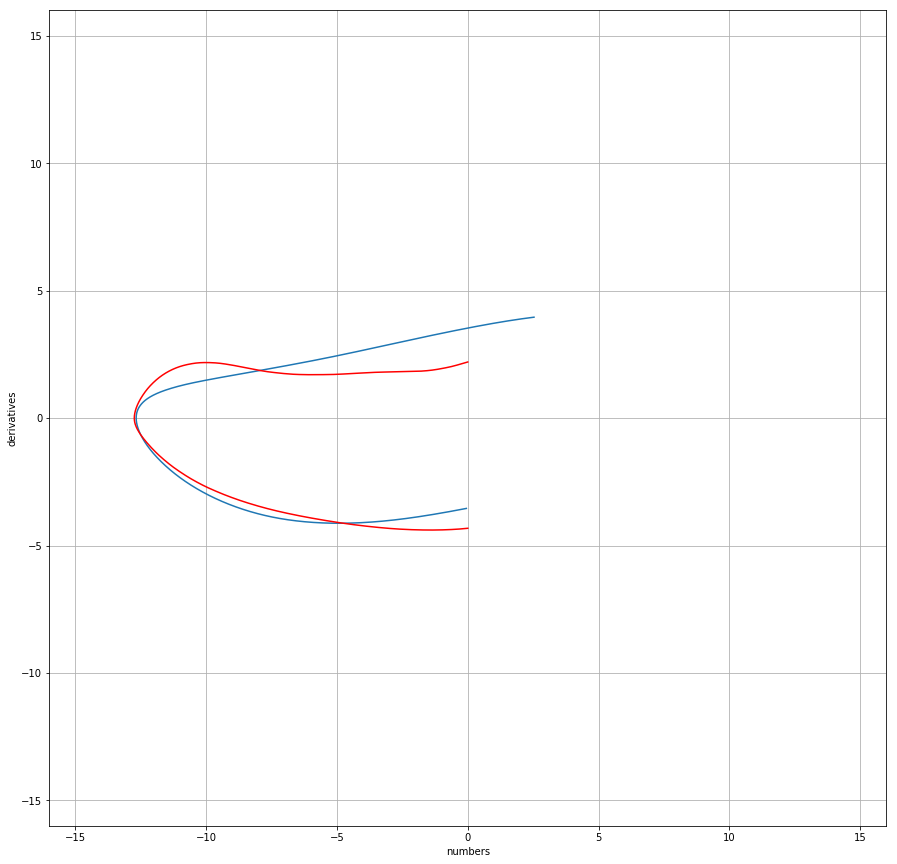

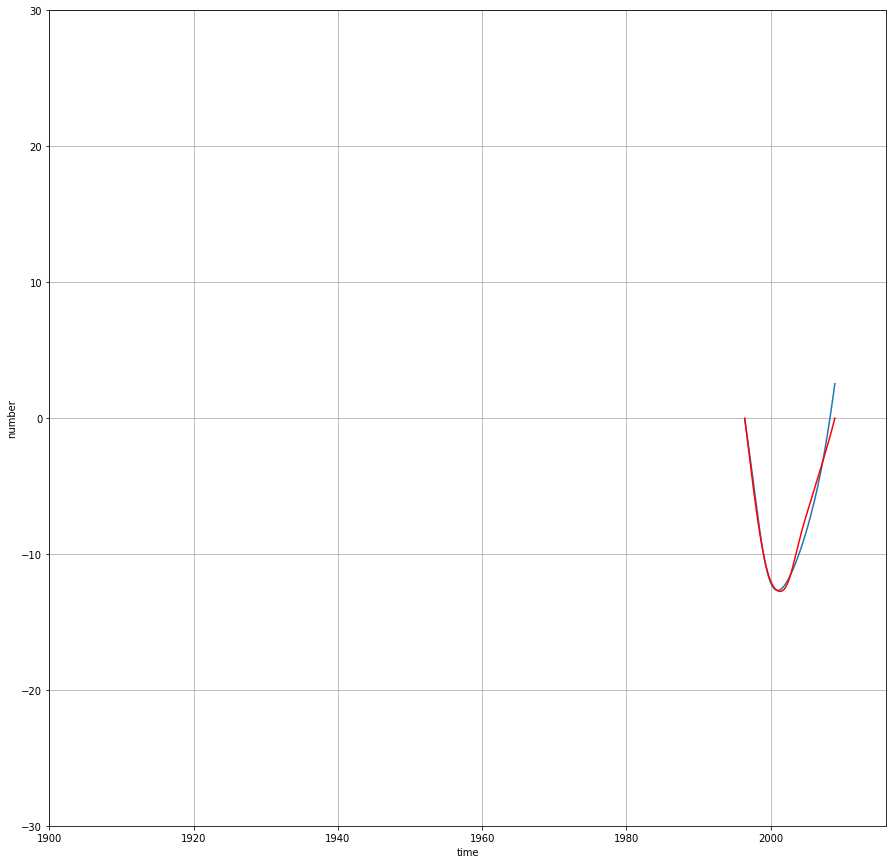

cicle 11
mistake = 0.026429093595019132
lamda = 0.0008
mu = 0.301
eps = 0.0427
omega = 0.1305


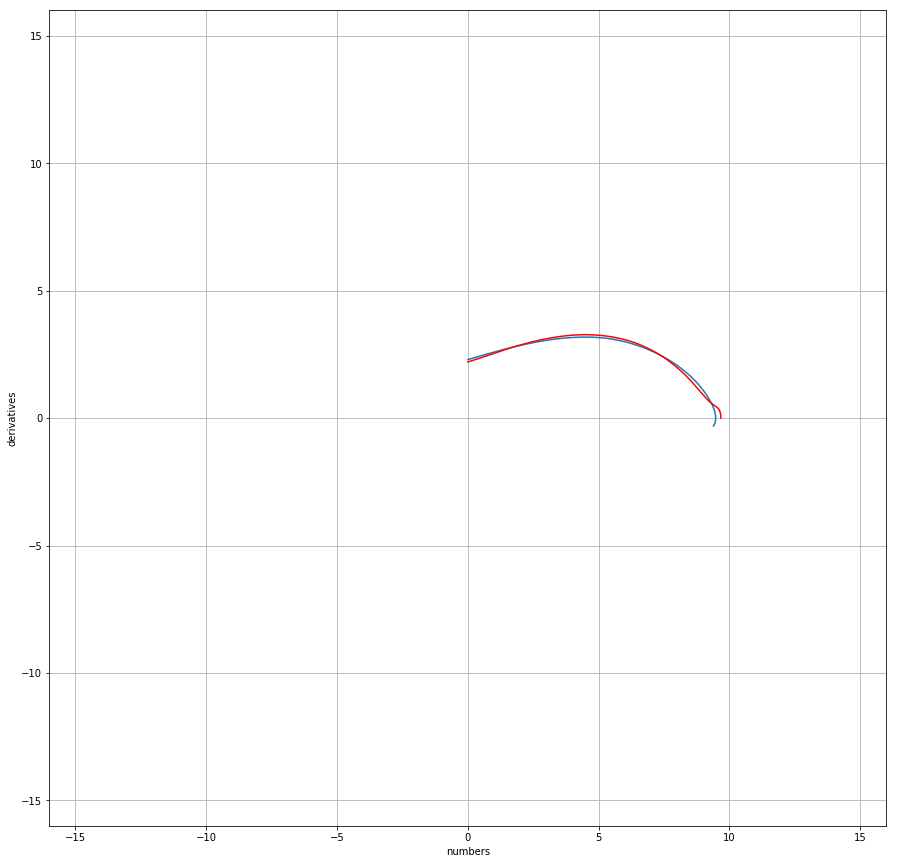

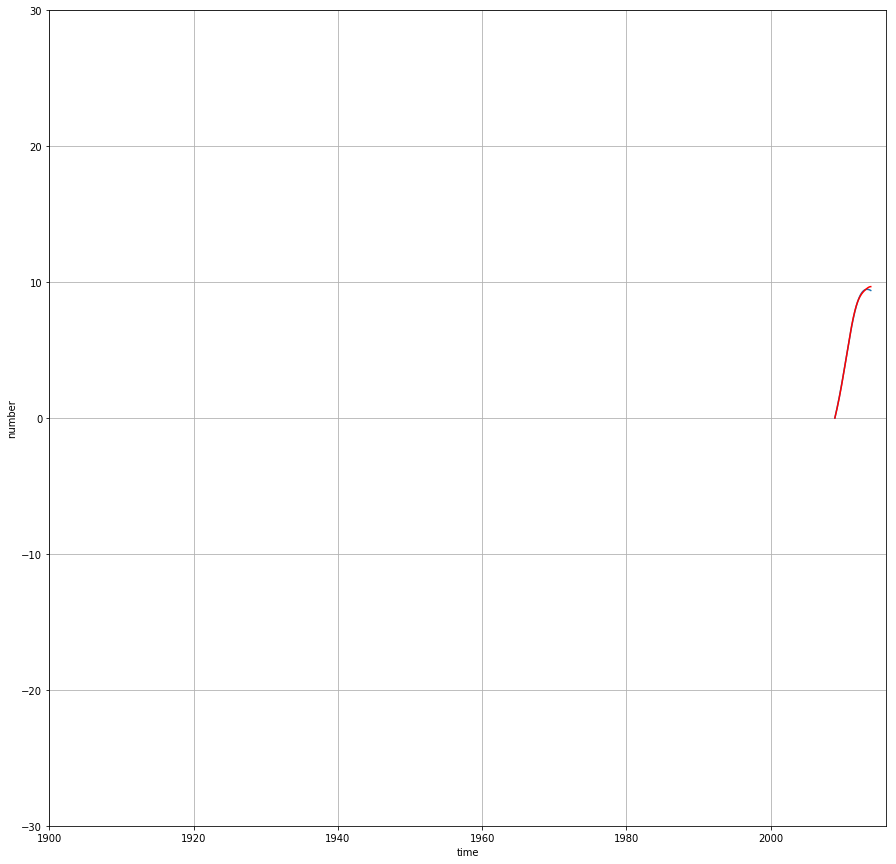

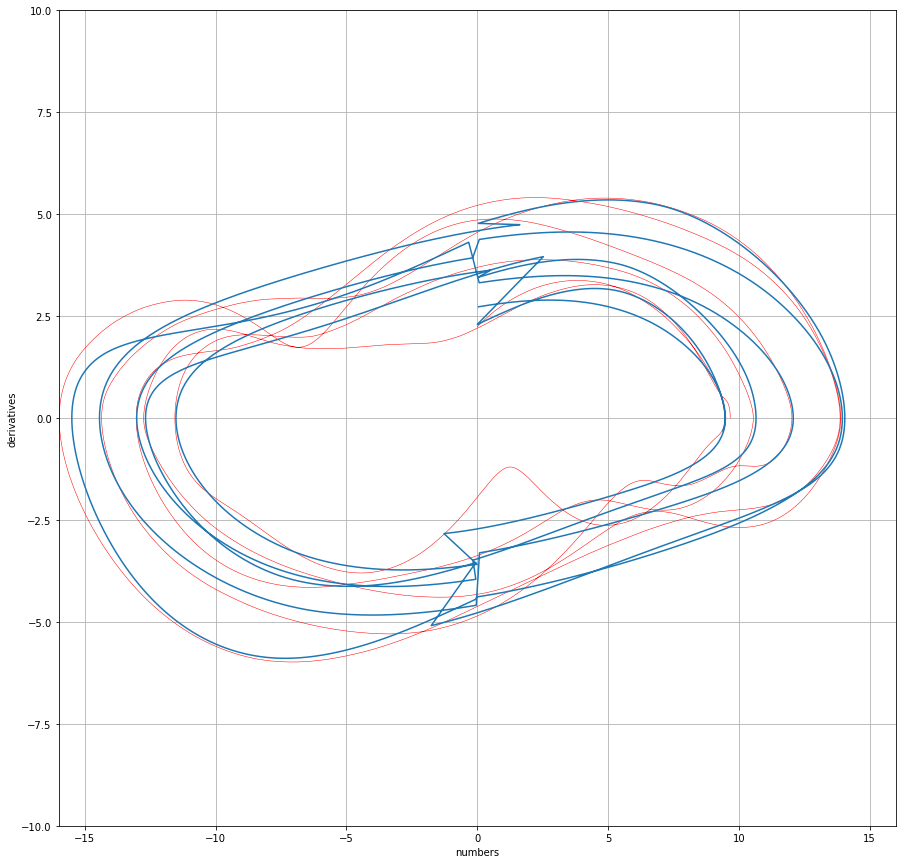

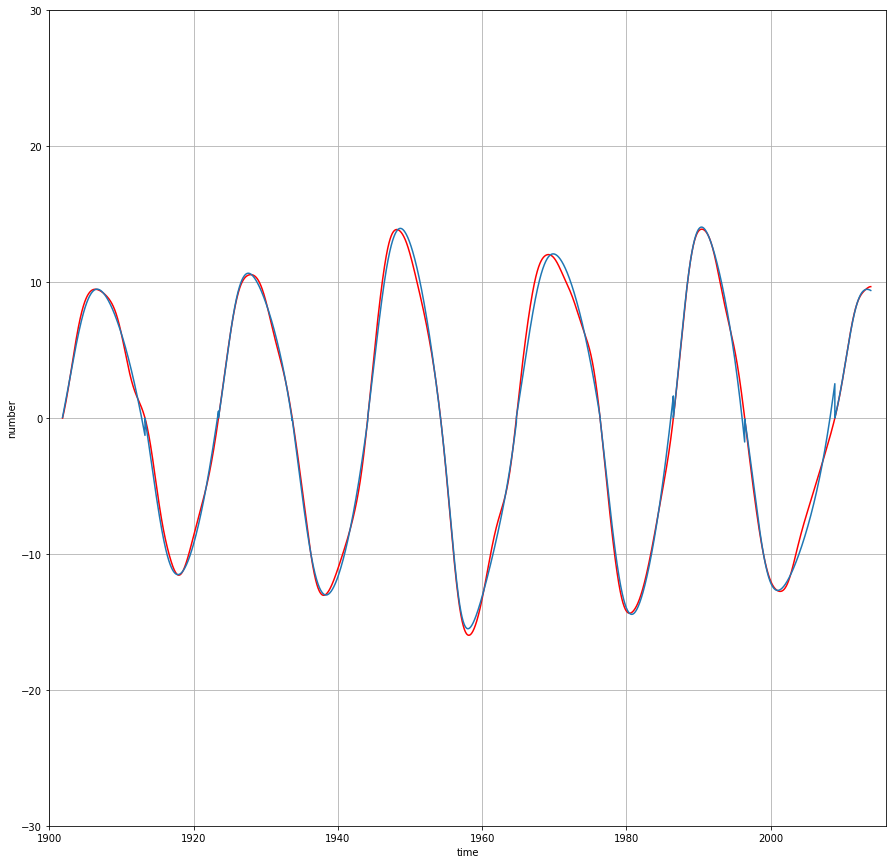

In [31]:
cicles_num = len(cicles)
total_result = []
for i in range (0, cicles_num):
    result_data = approximate_cicle(i)
    total_result.append(result_data[1][0])
    drow_cicle_results(result_data, i)
all_approx_data = np.concatenate(total_result, axis = 1)
draw_cicles(portraits, -1)
plt.plot(all_approx_data[0,:], all_approx_data[1,:])
plt.show()
add_graph_parametrs()
data_span = smoothed_data[cicles[0][0]:cicles[-1][1] + 1, :]
plt.plot(data_span[:, 0], data_span[:, 1], color='r')
plt.plot(data_span[:, 0], all_approx_data[0, :])
plt.show()

In [32]:
#theory check 2.0
def args_from_time(portrait, c_data):
    eps_t = []
    lamda_t = []
    mu_t = []
    omega_t = []
    integ = integrate(c_data)
    integ_3deg = integrate_3deg(c_data)
    events_num = len(c_data)
    init_x = np.array([[portrait[0, 0]], [portrait[0, 0]], [portrait[0, 0]], [portrait[0, 0]]])
    init_dev = np.array([[portrait[0, 1]], [portrait[0, 1]], [portrait[0, 1]], [portrait[0, 1]]])
    for i in range (3, events_num - 2):
        A_1 = integ_3deg[i - 2 : i + 2, 1:2]
        dev = portrait[i - 2 : i + 2, 1:2]
        x = portrait[i - 2 : i + 2, 0:1]
        A_2 = 1 / 3 * (x ** 3 - init_x ** 3)
        A_3 = integ[i - 2 : i + 2, 1:2]
        A_4 = dev - init_dev
        V = x - init_x
        V = V[:,0]
        A = np.concatenate((A_1, A_2, A_3, A_4), axis = 1)
        Sol = np.linalg.solve(A, V)
        m = 1 / Sol[3]
        mu_t.append([c_data[i, 0], m])
        eps_t.append([c_data[i, 0], Sol[1]])
        omega_t.append([c_data[i, 0], Sol[2] * m])
        lamda_t.append([c_data[i, 0], Sol[0] * m])
    return [np.array(eps_t), np.array(lamda_t), np.array(mu_t), np.array(omega_t)]

In [33]:
def integrate(data):
    int_sum = 0
    res = [[data[0, 0], int_sum]]
    events_num = len(data)
    for i in range(1, events_num):
        int_sum += 0.5 * (data[i, 1] + data[i - 1, 1]) * (data[i, 0] - data[i - 1, 0])
        res.append([data[i, 0], int_sum])
    return np.array(res)

In [34]:
def integrate_3deg(data):
    int_sum = 0
    res = [[data[0, 0], int_sum]]
    events_num = len(data)
    for i in range(1, events_num):
        int_sum += 0.5 * (data[i, 1] ** 3 + data[i - 1, 1] ** 3) * (data[i, 0] - data[i - 1, 0])
        res.append([data[i, 0], int_sum])
    return np.array(res)

In [35]:
c_data = smoothed_data[cicles[0][0] : cicles[0][1] + 1]
X = args_from_time(portraits[0], c_data)

[-0.45108376 -0.19016167  0.48003806 ... -1.38679365 -2.39950363
 -3.36180847]


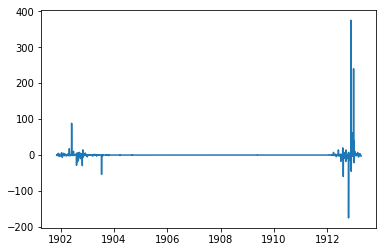

In [36]:
plt.plot(X[0][:,0], X[0][:,1])
print(X[0][:,1])

[ 2.26303692e+01  1.38428001e+01 -3.48482612e+00 ... -2.43275030e-03
 -1.22843564e-03 -3.26558509e-04]


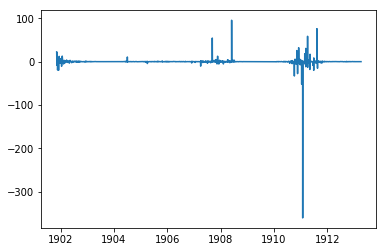

In [37]:
plt.plot(X[1][:,0], X[1][:,1])
print(X[1][:,1])

[0.66947371 0.66946582 0.66943061 ... 0.79073944 0.7912047  0.79147528]


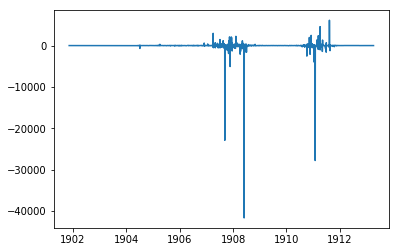

In [38]:
plt.plot(X[2][:,0], X[2][:,1])
print(X[2][:,1])

[0.62981479 0.62482494 0.60767481 ... 0.21421773 0.1391     0.08284645]


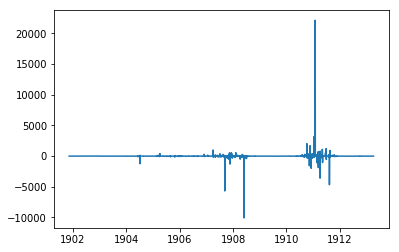

In [39]:
plt.plot(X[3][:,0], X[3][:,1])
print(X[3][:,1])

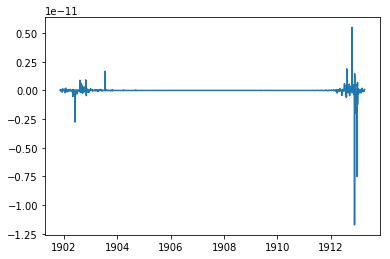

In [40]:
#attept
fc = 1000
b = 0.0022
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = np.blackman(N)
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

sinc_func = -sinc_func
sinc_func[int((N - 1) / 2)] += 1

s = list(X[0][:,1])
new_signal = np.convolve(s, sinc_func, mode='same')
plt.plot(X[0][:,0], new_signal)

In [ ]:
#seems more real